<a href="https://colab.research.google.com/github/VanChung-Nguyen/Nonlinear-and-Data-Driven-Estimation-3D-Drone/blob/main/obserabilitydrone.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import matplotlib as mpl

from scipy.integrate import odeint
import scipy.optimize

import sympy as sp

import pandas as pd

import copy

In [2]:
try:
    import casadi
except:
    !pip install casadi
    import casadi

try:
    import do_mpc
except:
    !pip install do_mpc
    import do_mpc

try:
    import pybounds
except:
    #!pip install pybounds
    !pip install git+https://github.com/vanbreugel-lab/pybounds
    import pybounds

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 75.6/75.6 MB 31.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 162.9/162.9 kB 17.4 MB/s eta 0:00:00


/usr/local/lib/python3.12/dist-packages/do_mpc/sysid/__init__.py:15: UserWarning: The ONNX feature is not available. Please install the full version of do-mpc to access this feature.
  warnings.warn('The ONNX feature is not available. Please install the full version of do-mpc to access this feature.')
/usr/local/lib/python3.12/dist-packages/do_mpc/opcua/__init__.py:14: UserWarning: The opcua feature is not available. Please install the full version of do-mpc to access this feature.
  warnings.warn('The opcua feature is not available. Please install the full version of do-mpc to access this feature.')


  Cloning https://github.com/vanbreugel-lab/pybounds to /tmp/pip-req-build-uw1rddgf
  Running command git clone --filter=blob:none --quiet https://github.com/vanbreugel-lab/pybounds /tmp/pip-req-build-uw1rddgf
  Resolved https://github.com/vanbreugel-lab/pybounds to commit a2a55f7d1bcb0962b780d9973b2bc2ada29589de
  Preparing metadata (setup.py) ... done
  Created wheel for pybounds: filename=pybounds-0.0.13-py3-none-any.whl size=19534 sha256=66c0e8169aace79a969f003d5882263d81f90bc1b98d9d8c3566925f8dd0b62b
  Stored in directory: /tmp/pip-ephem-wheel-cache-revcfsv9/wheels/cb/f8/fb/ff1887f9a2f35c3edad7b1acb7da69437c1fd8d885a800578d
Successfully built pybounds


In [3]:
import sys
import requests
import importlib
import importlib.util
from pathlib import Path

def import_local_or_github(package_name, function_name=None, directory=None, giturl=None):
    # 1) Try local import
    try:
        if directory is not None:
            directory = str(Path(directory).resolve())
            if directory not in sys.path:
                sys.path.insert(0, directory)
        module = importlib.import_module(package_name)
        return getattr(module, function_name) if function_name else module
    except ModuleNotFoundError:
        pass  # fall through to GitHub fetch
    except Exception as e:
        # If module exists but some other error occurred, surface it
        raise

    # 2) Fetch from GitHub (RAW)
    if giturl is None:
        giturl = (
            "https://raw.githubusercontent.com/"
            "VanChung-Nguyen/ME-793-Mathematical-model-simulation-of-3D-Drone/"
            f"main/Utility/{package_name}.py"
        )

    try:
        headers = {"User-Agent": "import_local_or_github/1.0"}
        r = requests.get(giturl, headers=headers, timeout=15)
        r.raise_for_status()
    except requests.RequestException as e:
        raise RuntimeError(f"Failed to fetch module from GitHub URL:\n{giturl}\nError: {e}")

    # Save to CWD as {package_name}.py so Python can import it
    target_path = Path.cwd() / f"{package_name}.py"
    target_path.write_text(r.text, encoding=r.encoding or "utf-8")

    # Make sure Python sees the new file
    importlib.invalidate_caches()

    # 3) Import the freshly written module
    module = importlib.import_module(package_name)
    return getattr(module, function_name) if function_name else module


# Usage
drone = import_local_or_github('drone', directory='../Utility')
plot_tme = import_local_or_github('plot_utility', function_name='plot_tme', directory='../Utility')


In [4]:
f = drone.F().f
h = drone.H('h_opticalimuz').h

In [5]:
t_sim, x_sim, u_sim, y_sim, simulator = drone.simulate_drone(f, h=h, dt=0.1, tsim_length= 40,trajectory_shape='circle')

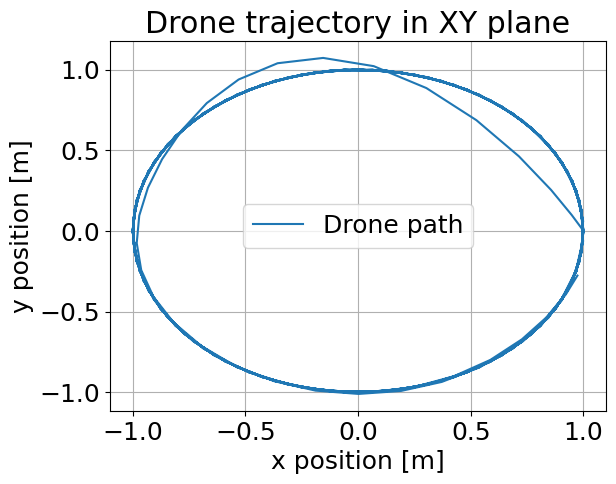

In [6]:
fig = plt.figure()
ax = fig.add_subplot(111)

# Plot X–Y trajectory
ax.plot(x_sim['x'], x_sim['y'], label='Drone path')

ax.set_xlabel('x position [m]')
ax.set_ylabel('y position [m]')
ax.set_title('Drone trajectory in XY plane')
ax.legend()
ax.grid(True)
plt.show()


In [14]:
measurement_noise_stds = {'z': 0.1,
                          'optic_flow_x': 0.5,
                          'optic_flow_y': 0.5,
                          'phi': 0.1,
                          'theta': 0.1,
                          'psi': 0.1,
                          'phidot': 0.1,
                          'thetadot': 0.1,
                          'psidot': 0.1,
                          'ax': 0.2,
                          'ay': 0.2,
                          'az': 0.2,
                         }

In [24]:
u_sim_df = pd.DataFrame(u_sim)
x_sim_df = pd.DataFrame(x_sim)
w = 15

In [25]:
SEOM = pybounds.SlidingEmpiricalObservabilityMatrix(simulator, t_sim, x_sim, u_sim, w=w, eps=1e-4)

# Get O's
O_sliding = SEOM.get_observability_matrix()

In [26]:
n_window = len(O_sliding)
print(n_window, 'windows')

386 windows


In [27]:
O_sliding[0]

,,x,y,z,phi,theta,psi,xdot,ydot,zdot,phidot,thetadot,psidot
sensor,time_step,,,,,,,,,,,,
z,0,0.000000e+00,0.000000e+00,1.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000
optic_flow_x,0,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,1.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000
optic_flow_y,0,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,1.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000
phi,0,0.000000e+00,0.000000e+00,0.000000e+00,1.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000
theta,0,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,1.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000
...,...,...,...,...,...,...,...,...,...,...,...,...,...
thetadot,14,3.626960e-10,9.343221e-11,-3.986395e-11,-3.871972e-09,-1.555353e-10,-1.417269e-09,5.428297e-10,1.339900e-10,-9.183626e-11,-6.274242e-04,9.999998e-01,-0.004973
psidot,14,-7.719519e-13,-1.266348e-12,-4.163336e-13,4.336809e-14,4.510281e-13,-7.112366e-13,8.933826e-13,-1.327063e-12,-3.556183e-13,-5.984796e-13,2.341877e-13,1.000000
ax,14,2.591261e-09,-4.241052e-10,-3.264056e-10,2.441277e-02,1.005681e+01,-1.742591e-01,4.822809e-09,-4.707346e-10,-1.398881e-10,9.808309e-02,1.407917e+01,0.512193


In [28]:
measurement_noise_vars = {key: val**2 for key, val in measurement_noise_stds.items()}

In [29]:
FO = pybounds.FisherObservability(SEOM.O_df_sliding[0], measurement_noise_vars, lam=1e-8)

In [30]:
F, F_inv, R = FO.get_fisher_information()
F_inv

,x,y,z,phi,theta,psi,xdot,ydot,zdot,phidot,thetadot,psidot
x,9.999954e+07,-1.311700e+02,-0.449531,0.004805,0.016053,0.012337,0.900017,-1.779972,1.332043,-0.001515,-0.024189,-0.004652
y,-1.311700e+02,9.999995e+07,-0.216940,0.003112,0.001795,0.003726,-0.039869,-0.479896,0.773429,-0.005568,0.001161,-0.001387
z,-4.495308e-01,-2.169404e-01,0.002368,0.000008,0.000019,0.000020,-0.000520,0.000943,-0.002492,-0.000018,-0.000010,-0.000031
phi,4.804709e-03,3.111860e-03,0.000008,0.000078,-0.000010,-0.000044,0.000022,0.000227,-0.000072,-0.000083,0.000016,0.000015
theta,1.605273e-02,1.795258e-03,0.000019,-0.000010,0.000083,0.000042,-0.000255,-0.000008,-0.000088,0.000011,-0.000084,-0.000027
psi,1.233709e-02,3.726411e-03,0.000020,-0.000044,0.000042,0.000253,0.000012,-0.000008,-0.000049,0.000041,-0.000030,-0.000251
xdot,9.000167e-01,-3.986932e-02,-0.000520,0.000022,-0.000255,0.000012,0.023770,-0.000037,0.000089,-0.000022,0.000164,-0.000028
ydot,-1.779972e+00,-4.798962e-01,0.000943,0.000227,-0.000008,-0.000008,-0.000037,0.023463,-0.001191,-0.000146,0.000003,0.000022
zdot,1.332043e+00,7.734286e-01,-0.002492,-0.000072,-0.000088,-0.000049,0.000089,-0.001191,0.003701,0.000099,0.000049,0.000105
phidot,-1.515177e-03,-5.567532e-03,-0.000018,-0.000083,0.000011,0.000041,-0.000022,-0.000146,0.000099,0.000118,-0.000021,0.000001


In [31]:
o_sensors = h(None, None, return_measurement_names=True)

# Chose states to use from O
o_states = ['x', 'y', 'z', 'phi', 'theta', 'psi', 'xdot', 'ydot', 'zdot', 'phidot', 'thetadot', 'psidot']

# Choose time-steps to use from O
window_size = 6 # this cannot be larger than what was defined above
o_time_steps = np.arange(0, window_size, step=1)

# Redefine R -- if you remove a sensor you need to change R
o_measurement_noise_vars = {key: measurement_noise_vars[key] for key in o_sensors}

In [32]:
SFO = pybounds.SlidingFisherObservability(SEOM.O_df_sliding, time=SEOM.t_sim, lam=1e-8, R=o_measurement_noise_vars,
                                 states=o_states, sensors=o_sensors, time_steps=o_time_steps, w=None)

In [33]:
EV_aligned = SFO.get_minimum_error_variance()

In [34]:
EV_no_nan = EV_aligned.fillna(method='bfill').fillna(method='ffill')

/tmp/ipython-input-1416315243.py:1: FutureWarning: DataFrame.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  EV_no_nan = EV_aligned.fillna(method='bfill').fillna(method='ffill')


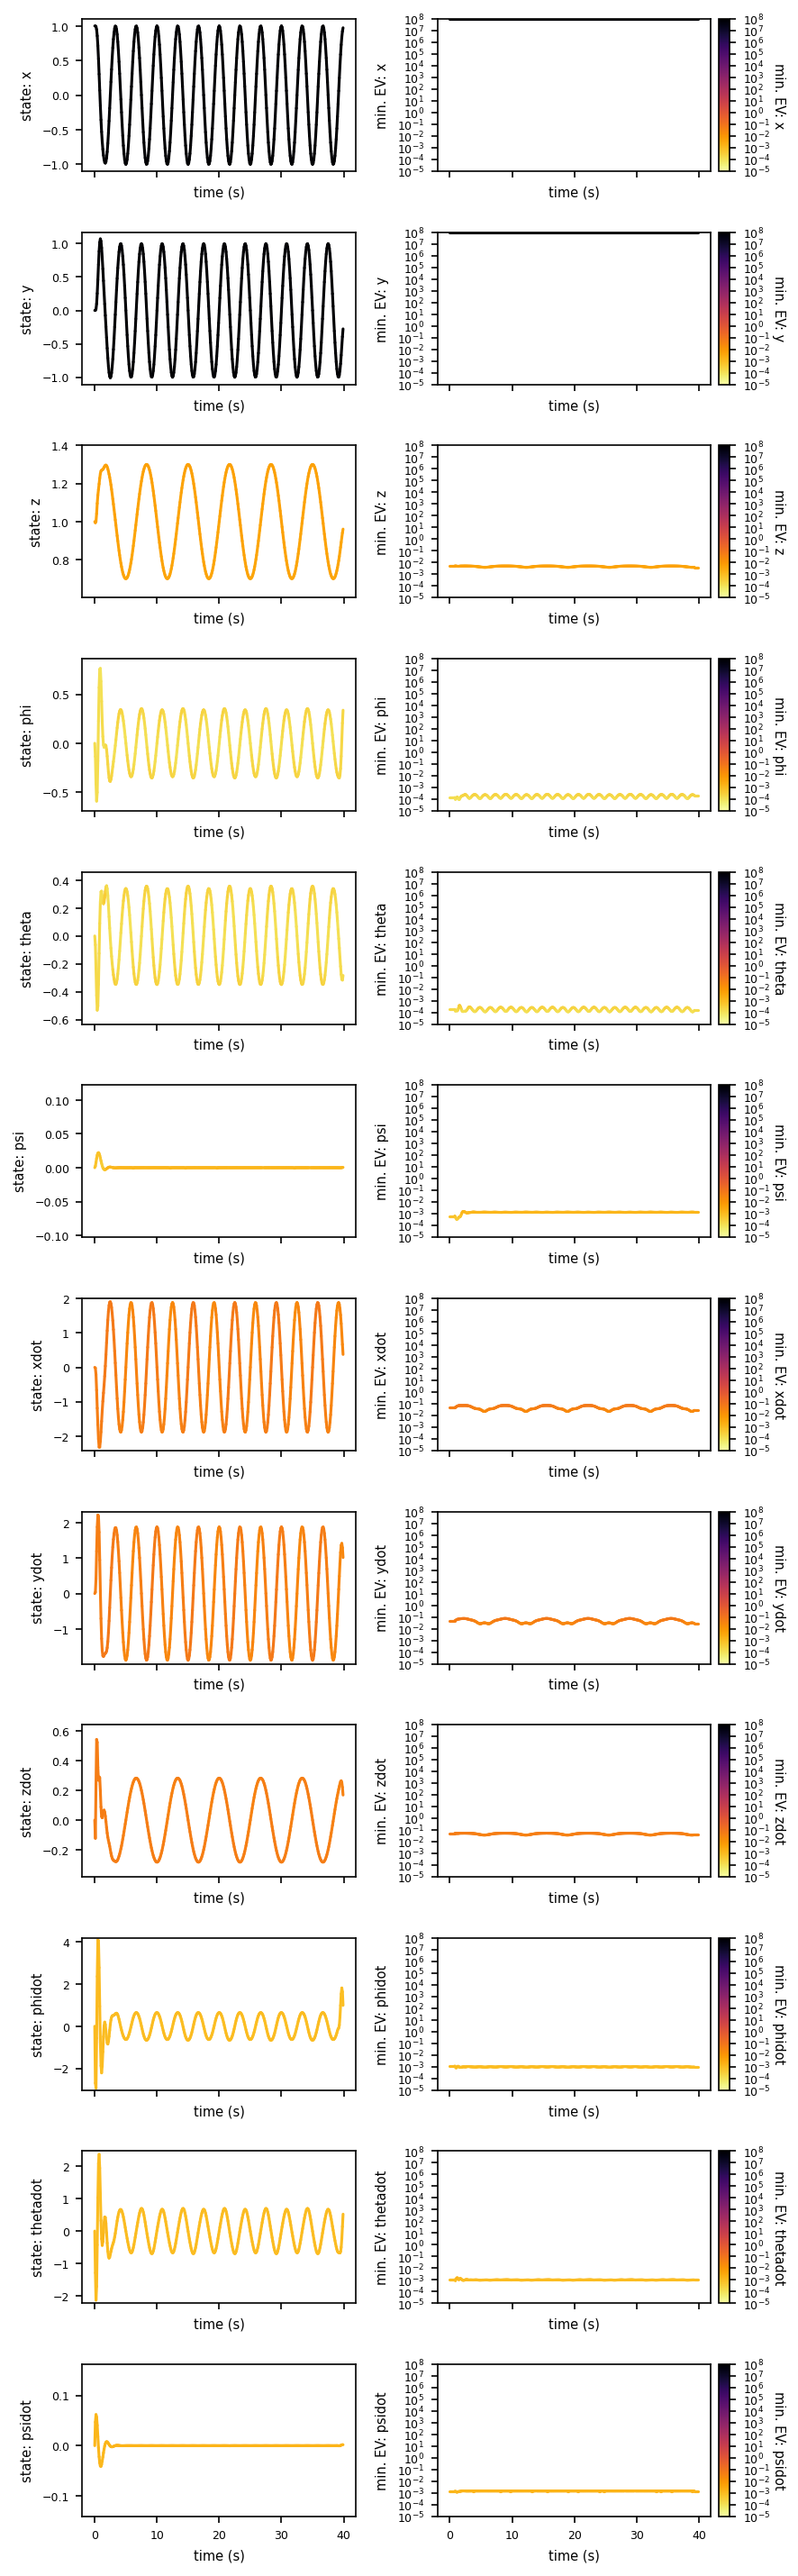

In [35]:
states = list(SFO.FO[0].O.columns)
n_state = len(states)

fig, ax = plt.subplots(n_state, 2, figsize=(6, n_state*2), dpi=150, sharex=True)
ax = np.atleast_2d(ax)

cmap = 'inferno_r'

min_ev = np.min(EV_no_nan.iloc[:, 2:].values)
max_ev = np.max(EV_no_nan.iloc[:, 2:].values)

log_tick_high = int(np.ceil(np.log10(max_ev)))
log_tick_low = int(np.floor(np.log10(min_ev)))
cnorm = mpl.colors.LogNorm(10**log_tick_low, 10**log_tick_high)

for n, state_name in enumerate(states):
    pybounds.colorline(t_sim, x_sim[state_name], EV_no_nan[state_name].values, ax=ax[n, 0], cmap=cmap, norm=cnorm)
    pybounds.colorline(t_sim, EV_no_nan[state_name].values, EV_no_nan[state_name].values, ax=ax[n, 1], cmap=cmap, norm=cnorm)

    # Colorbar
    cax = ax[n, -1].inset_axes([1.03, 0.0, 0.04, 1.0])
    cbar = fig.colorbar(mpl.cm.ScalarMappable(norm=cnorm, cmap=cmap), cax=cax,
                        ticks=np.logspace(log_tick_low, log_tick_high, log_tick_high-log_tick_low + 1))
    cbar.set_label('min. EV: ' + state_name, rotation=270, fontsize=7, labelpad=8)
    cbar.ax.tick_params(labelsize=6)

    x_max = np.max(x_sim[state_name])
    x_min = np.min(x_sim[state_name])

    ax[n, 0].set_ylim(x_min - 0.1, x_max + 0.1)
    ax[n, 0].set_ylabel('state: ' + state_name, fontsize=7)

    ax[n, 1].set_ylim(10**log_tick_low, 10**log_tick_high)
    ax[n, 1].set_yscale('log')
    ax[n, 1].set_ylabel('min. EV: ' + state_name, fontsize=7)
    ax[n, 1].set_yticks(np.logspace(log_tick_low, log_tick_high, log_tick_high-log_tick_low + 1))

for a in ax.flat:
    a.tick_params(axis='both', labelsize=6)
    a.set_xlabel('time (s)', fontsize=7)
    offset = t_sim[-1] * 0.05
    a.set_xlim(-offset, t_sim[-1] + offset)

fig.subplots_adjust(left=None, bottom=None, right=None, top=None, wspace=0.3, hspace=0.4)